In [1]:
# NOTE : Must be run from the notebooks/ folder to work

import sys
import os

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from src.data_loading import load_ticker_by_symbol
from src.data_cleaning import validate_and_clean
from src.feature_engineering import add_returns

In [2]:
# Path to stocks folder
folder = os.path.join(PROJECT_ROOT, "stocks_dataset", "stocks")

# Load a single ticker and clean it
df_raw = load_ticker_by_symbol(folder, "AAPL")
df_clean = validate_and_clean(df_raw)

# Preview
df_clean.head()

,date,open,high,low,close,adj_close,volume
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400


In [3]:
df_features = add_returns(df_clean, price_col="adj_close", method="log")
df_features.head()

,date,open,high,low,close,adj_close,volume,returns
0,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200,-0.053584
1,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000,-0.076227
2,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400,0.024451
3,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400,0.028574
4,1980-12-19,0.504464,0.506696,0.504464,0.504464,0.399707,12157600,0.059243


In [4]:
from src.sequence_prep import create_lstm_sequences

LOOKBACK = 30

X, y = create_lstm_sequences(
    df_features,
    feature_col="returns",
    target_col="returns",
    lookback=LOOKBACK
)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (9878, 30, 1)
y shape: (9878,)


In [5]:
from src.data_split import time_series_split

X_train, y_train, X_val, y_val, X_test, y_test = time_series_split(X, y)

print("Train samples:", X_train.shape[0])
print("Validation samples:", X_val.shape[0])
print("Test samples:", X_test.shape[0])

Train samples: 6914
Validation samples: 1482
Test samples: 1482


In [6]:
from src.model_lstm import build_lstm_model

model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]), loss="Huber")

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)

Epoch 1/20


/Users/thiba/Documents/EPFL/M1/Q1/Applied Data Analysis/LSTM_StockPrediction/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.8253e-04 - val_loss: 1.1687e-04
Epoch 2/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8203e-04 - val_loss: 1.0967e-04
Epoch 3/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8100e-04 - val_loss: 1.0818e-04
Epoch 4/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8149e-04 - val_loss: 1.1196e-04
Epoch 5/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8111e-04 - val_loss: 1.0827e-04
Epoch 6/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8120e-04 - val_loss: 1.0838e-04
Epoch 7/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8090e-04 - val_loss: 1.0842e-04
Epoch 8/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8068e-04 - val_loss: 1.0902e-04
Epoch 9/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8077e-04 - val_loss: 1.0848e-04
Epoch 10/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8108e-04 - val_loss: 1.1112e-04
Epoch 11/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8054e-0

#### Evaluate on test set

In [7]:
test_loss = model.evaluate(X_test, y_test, verbose=0)
print("Test MSE:", test_loss)

Test MSE: 7.764504698570818e-05


#### Baseline 1 : Always predict 0

In [9]:
import numpy as np

y_zero = np.zeros_like(y_test)
mse_zero = np.mean((y_test - y_zero) ** 2)

print("Zero-return baseline MSE:", mse_zero)

Zero-return baseline MSE: 0.0002995655759925237


#### Baseline 2 : Tomorrow = Today

In [10]:
last_returns = X_test[:, -1, 0]
mse_naive = np.mean((y_test - last_returns) ** 2)

print("Naive baseline MSE:", mse_naive)

Naive baseline MSE: 0.0006538142425455466


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


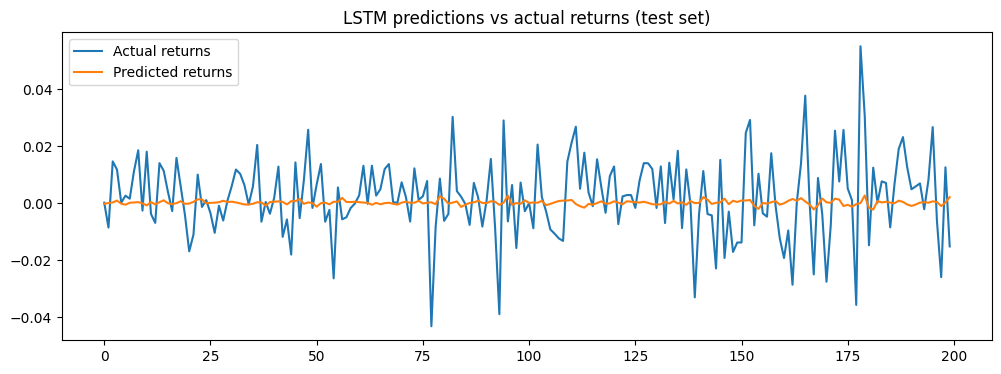

In [11]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test).flatten()

plt.figure(figsize=(12, 4))
plt.plot(y_test[:200], label="Actual returns")
plt.plot(y_pred[:200], label="Predicted returns")
plt.legend()
plt.title("LSTM predictions vs actual returns (test set)")
plt.show()